# Simple Siamese Network Implementation

Implementation is done to get understanding of how contrastive learn work, which will help to implement FYP project

### Dataset

Used AT&T Dataset

Can Be Found At : https://www.kaggle.com/datasets/kasikrit/att-database-of-faces

In [1]:
TRAINING_PATH = "att_data/training"
TESTING_PATH = "att_data/testing"

### Configure and Import Required Libraries

In [2]:
%matplotlib inline

In [3]:
import os
import random
import torch
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

### Preparing Dataset

There are three persons in dataset. And each one containing 10 images. In order to train good neural network we need to precent class imbalance. Where we need to choose pair of images such that, 50% of images related to person and 50% images related to different person

Let's list all image paths and give tag

##### Train Dict

In [4]:
content_of_training_directory = os.listdir(TRAINING_PATH)
train_img_dict = []

for tag in content_of_training_directory:
    
    images_under_tag = os.listdir(TRAINING_PATH+"/"+tag)
    
    for image in images_under_tag:
        
        image_location = TRAINING_PATH+"/"+tag+"/"+image
        img = Image.open(image_location)
        
        img.convert("L")
        img.resize((100,100))
        
        transform = transforms.Compose([transforms.PILToTensor()])
        tensor = transform(img)
        train_img_dict.append((tensor, tag))

random.shuffle(train_img_dict)
train_img_dict[0]

(tensor([[[116, 123, 120,  ..., 123, 121, 124],
          [119, 121, 123,  ..., 119, 123, 123],
          [118, 123, 121,  ..., 121, 122, 119],
          ...,
          [ 69,  67,  70,  ..., 100,  97,  96],
          [ 69,  69,  68,  ...,  96,  96,  98],
          [ 69,  65,  72,  ..., 108,  96,  98]]], dtype=torch.uint8),
 's37')

#### Test Dict

In [5]:
content_of_training_directory = os.listdir(TESTING_PATH)
test_img_dict = []

for tag in content_of_training_directory:
    
    images_under_tag = os.listdir(TESTING_PATH+"/"+tag)
    
    for image in images_under_tag:
        
        image_location = TESTING_PATH+"/"+tag+"/"+image
        img = Image.open(image_location)
        
        img.convert("L")
        img.resize((100,100))
        
        transform = transforms.Compose([transforms.PILToTensor()])
        tensor = transform(img)
        test_img_dict.append((tensor, tag))

random.shuffle(test_img_dict)
test_img_dict[0]

(tensor([[[133, 132, 131,  ..., 124, 123, 120],
          [133, 130, 130,  ..., 123, 123, 123],
          [131, 132, 130,  ..., 123, 122, 125],
          ...,
          [105,  99, 106,  ...,  52,  53,  55],
          [106, 101, 107,  ...,  51,  54,  52],
          [108, 112, 116,  ...,  53,  48,  58]]], dtype=torch.uint8),
 's5')

Image Dict Contain Images And Tag as (PIL_IMAGE, TAG)

Now we need to make a batch with 50% similarity 

In [6]:
def load_a_batch(batchsize,img_dict):
    
    # Content -> List Of (Image_1_Tensor, Image_2_Tensor, Is_Similar_Boolean)
    output_list = []
    
    # Select Similar Images
    for i in range(batchsize//2):
        img_1 = random.choice(img_dict)
        while True:
            img_2 = random.choice(img_dict)
            if img_1[1]==img_2[1]:
                output_list.append((img_1[0],img_2[0],True))
                break
    
    # Select Dissimilar Images
    for i in range(batchsize//2,batchsize):
        img_1 = random.choice(img_dict)
        while True:
            img_2 = random.choice(img_dict)
            if img_1[1]!=img_2[1]:
                output_list.append((img_1[0],img_2[0],False))
                break
    
    # Shuffle
    random.shuffle(output_list)
    
    # Return
    return output_list
                

We need a function to view a batch

In [7]:
def batch_image(batch):
    list_of_vertical_joined = []
    is_similar = []
    for i in range(len(batch)):
        res = torch.cat((torch.squeeze(batch[i][0]), torch.squeeze(batch[i][1])), 0)
        list_of_vertical_joined.append(res)
        is_similar.append(batch[i][2])
    res = list_of_vertical_joined[0]
    for i in range(1,len(list_of_vertical_joined)): 
        res = torch.cat((res, list_of_vertical_joined[i]), 1)
    return transforms.ToPILImage()(res),is_similar

[True, False, True, False, True, False, False, False, True, True]


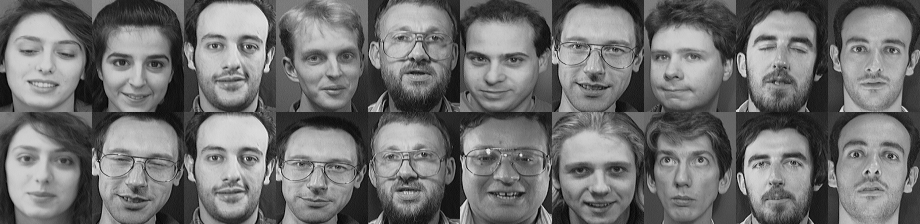

In [8]:
batch1 = load_a_batch(10,train_img_dict)
img,is_similar = batch_image(batch1)
print(is_similar)
img

In [9]:
def imshow(img, text=None):
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(img)
    plt.show() 

### Build Model

Here is how Siamese Network defined

![SiaMese Network Architecture](siamese.png)

In [10]:
class MySiameseNetwork(nn.Module):
    
    def __init__(self):
        super(MySiameseNetwork,self).__init__()
        
        self.cn_network = nn.Sequential(
            # Conv1
            nn.Conv2d(1,96,kernel_size =11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2),
            
            # Conv2
            nn.Conv2d(96,256,kernel_size =5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            
            # Conv3
            nn.Conv2d(256,384,kernel_size =3, stride=1),
            nn.ReLU(),       
        )
        
        self.fc_network = nn.Sequential(            
            # FC 1 
            nn.Linear(768,1024),
            # FC 2
            nn.Linear(1024,256),
            # FC 2
            nn.Linear(256,2)                
        )
        
             
        
    def SendThroughNetwork(self,image):        
        out_cn = self.cn_network(image)
        shape = out_cn.shape
        flatten_out = out_cn.view(shape[0],-1)
        output = self.fc_network(flatten_out)
        return output
    
    def GetInputsAndLabels(self,batch):
        image_1_list=[]
        image_2_list=[]
        labels = []
        
        for img1,img2,label in batch:
            image_1_list.append(torch.unsqueeze(img1,0))
            image_2_list.append(torch.unsqueeze(img2,0))
            labels.append(torch.unsqueeze(torch.tensor(int(label)),0))
        
        return torch.cat(image_1_list,dim=0).float(),torch.cat(image_2_list,dim=0).float(),torch.cat(labels,dim=0).float()
    
    def forward(self,image_1,image_2):
        
        # Send Two Images Through Same Network
        output1 = self.SendThroughNetwork(image_1)
        output2 = self.SendThroughNetwork(image_2)
        
        return output1,output2
        

In [11]:
siamese_network = MySiameseNetwork()
image_1_batch,image_2_batch,labels_batch =siamese_network.GetInputsAndLabels(batch1)

In [12]:
image_2_batch.shape

torch.Size([10, 1, 112, 92])

In [13]:
x1,x2 = siamese_network(image_1_batch,image_2_batch)

### Define Loss

In [14]:
def ContastiveLoss(x1, x2, label, margin: float = 1.0):

    dist = torch.nn.functional.pairwise_distance(x1, x2)

    loss = (1 - label) * torch.pow(dist, 2) \
        + (label) * torch.pow(torch.clamp(margin - dist, min=0.0), 2)
    loss = torch.mean(loss)

    return loss

In [15]:
ContastiveLoss(x1,x2,labels_batch)

tensor(0.5769, grad_fn=<MeanBackward0>)

### Function To Stack Batch

In [16]:
def stack(batch):
    img_1 = batch[0][0].unsqueeze(0).float()
    img_2 = batch[0][1].unsqueeze(0).float()
    labels = []
    for i in range(1,len(batch)):
        next_img = batch[i][0].unsqueeze(0)
        img_1 = torch.cat([img_1,next_img],dim=0).float()
    for i in range(1,len(batch)):
        next_img = batch[i][1].unsqueeze(0)
        img_2 = torch.cat([img_2,next_img],dim=0).float()
    for i in range(len(batch)):
        labels.append(torch.unsqueeze(torch.tensor(int(batch[i][2])),0).float())
    
    labels = torch.cat(labels, dim=0).float()
    
    return img_1,img_2,labels        

### Create Trian Dataset

In [17]:
train_dataset = []
no_of_batches = 20
batch_size = 50

for i in range(no_of_batches):
    batch = load_a_batch(batch_size,train_img_dict)
    dataset.append(stack(batch))

### Train Model

In [18]:
neural_network = MySiameseNetwork()
loss_func = ContastiveLoss
opt = torch.optim.Adam(neural_network.parameters(), lr = 0.001)

In [19]:
counter = []
history = []
iter_no    = 0

Epoch No : 0 Current Loss: 1.3606934547424316
Epoch No : 0 Current Loss: 2.3557066917419434
Epoch No : 1 Current Loss: 0.6683259606361389
Epoch No : 1 Current Loss: 0.47492286562919617
Epoch No : 2 Current Loss: 0.4946790635585785
Epoch No : 2 Current Loss: 0.43572497367858887
Epoch No : 3 Current Loss: 0.5046192407608032
Epoch No : 3 Current Loss: 0.43129318952560425
Epoch No : 4 Current Loss: 0.429977685213089
Epoch No : 4 Current Loss: 0.3953465223312378
Epoch No : 5 Current Loss: 0.3859800398349762
Epoch No : 5 Current Loss: 0.38812366127967834
Epoch No : 6 Current Loss: 0.35394468903541565
Epoch No : 6 Current Loss: 0.37215352058410645
Epoch No : 7 Current Loss: 0.33925098180770874
Epoch No : 7 Current Loss: 0.3351787328720093
Epoch No : 8 Current Loss: 0.3144926130771637
Epoch No : 8 Current Loss: 0.32457390427589417
Epoch No : 9 Current Loss: 0.3049527108669281
Epoch No : 9 Current Loss: 0.28827691078186035


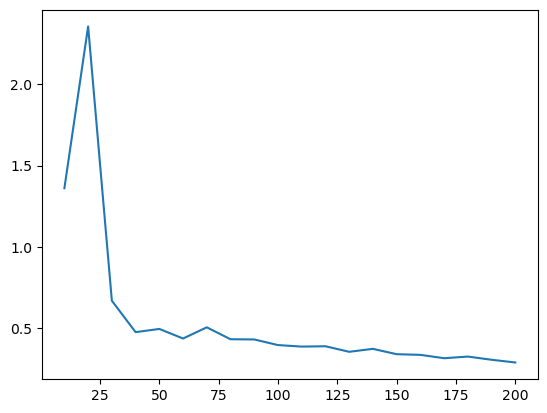

In [20]:
for epoch in range(10):
    i = 0
    for img_1,img_2,label in train_dataset:
        
        # Zero The Grads
        opt.zero_grad()
        
        # Get Outputs
        out1,out2 = neural_network(img_1,img_2)
        
        # Calc Loss
        loss = loss_func(out1,out2,label)
        
        # Calc Gradients
        loss.backward()
        
        # Update Weights
        opt.step()
        
        # Every 10 batch print result
        if i%10 ==0:
            print("Epoch No :",epoch,"Current Loss:",loss.item())
            iter_no+=10
            counter.append(iter_no)
            history.append(loss.item())
        
        i+=1
      
    
        
plt.plot(counter,history)
plt.show()

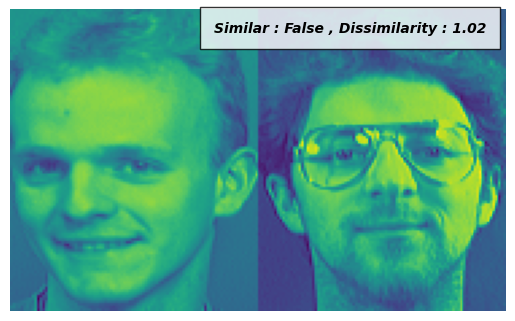

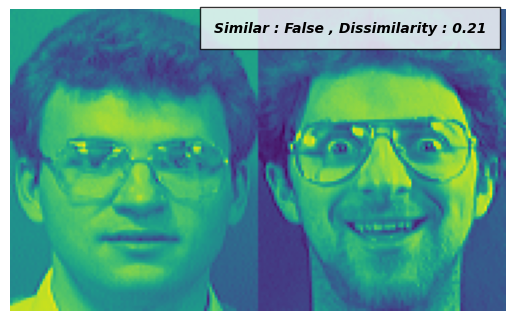

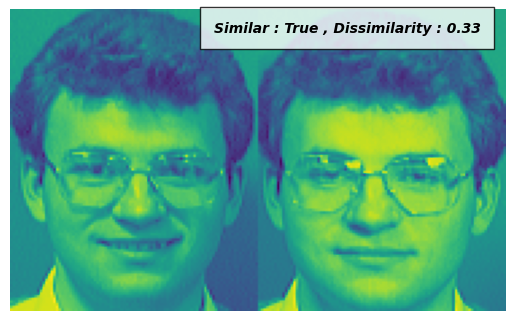

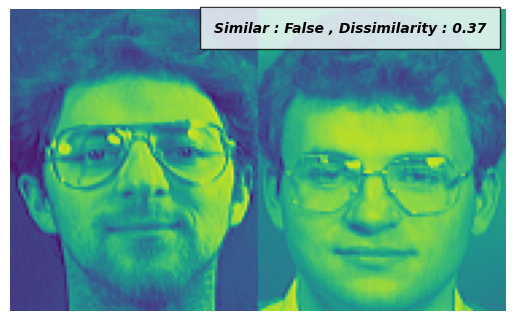

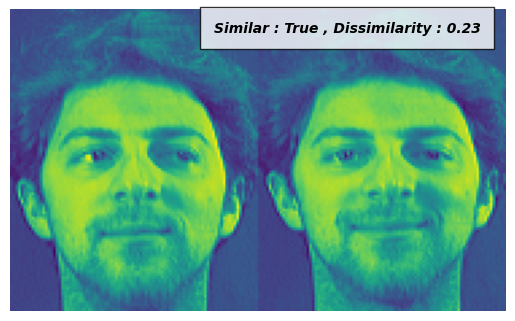

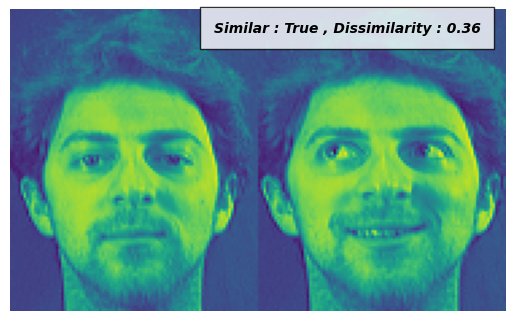

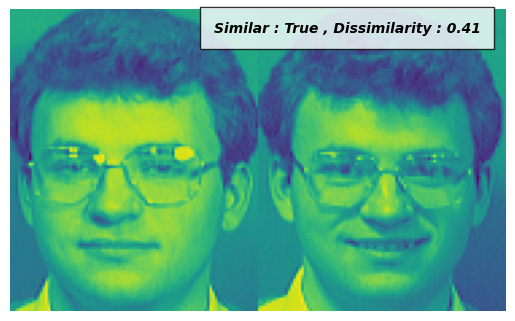

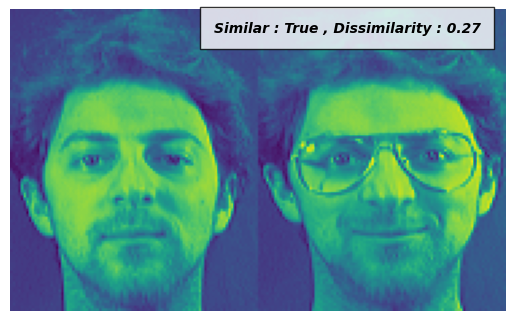

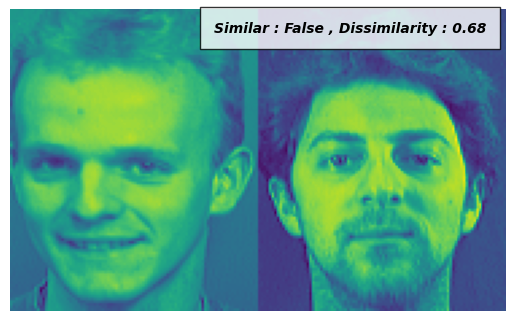

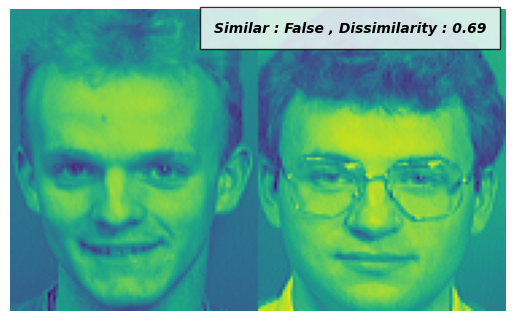

In [21]:
test_batch = load_a_batch(10,test_img_dict)
img_1,img_2,label = stack(test_batch)
out1,out2 = neural_network(img_1,img_2)
dist = list(F.pairwise_distance(out1,out2))

for i in range(len(test_batch)):
    
    res = torch.cat((img_1[i].squeeze(), img_2[i].squeeze()), 1).float()
    pil_img = transforms.ToPILImage()(res)
    text = f"Similar : {bool(label[i].item())} , Dissimilarity : {round(dist[i].item(),2)}"
    imshow(res,text)


In [22]:
test_batch[0]

(tensor([[[128, 125, 126,  ..., 125, 126, 123],
          [127, 127, 124,  ..., 124, 124, 124],
          [127, 127, 124,  ..., 125, 124, 127],
          ...,
          [ 87, 102,  94,  ...,  87,  86,  87],
          [103, 105,  92,  ...,  88,  83,  87],
          [ 92,  92,  89,  ...,  84,  85,  85]]], dtype=torch.uint8),
 tensor([[[67, 64, 67,  ..., 69, 69, 77],
          [70, 66, 69,  ..., 67, 73, 71],
          [67, 66, 62,  ..., 71, 71, 71],
          ...,
          [48, 46, 50,  ..., 65, 72, 82],
          [50, 50, 49,  ..., 72, 67, 71],
          [49, 48, 52,  ..., 73, 69, 72]]], dtype=torch.uint8),
 False)